# 01 - Regresión con Keras

En un problema de *regresión*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de *Clasificacion*, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga un perro o un gato queremos reconocer cual es el animal en la imagen).

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir la eficiencia de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

Este ejemplo usa el API `keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
# librerias

import warnings
warnings.filterwarnings('ignore')


import pylab as plt
import pandas as pd
import seaborn as sns


from keras.utils import get_file

from keras import Sequential
from keras.layers import Dense

from keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.optimizers.legacy import RMSprop  

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

### Conjunto de datos

Los datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)


In [2]:
data = get_file('auto-mpg.data', 
                'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
data

'/Users/iudh/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

In [4]:
df = pd.read_csv(data, 
                 names=column_names,
                 comment='\t', 
                 na_values = '?',
                 sep=' ', 
                 skipinitialspace=True)

In [5]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


### Limpieza y transformación de datos

In [7]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.Origin.unique()  # 1=USA, 2=Europa, 3=Japon

array([1, 3, 2])

In [10]:
df = pd.get_dummies(df, columns=['Origin'])

df.rename(columns = {'Origin_1': 'USA', 'Origin_2': 'Europe','Origin_3': 'Japan'}, inplace=True)

In [11]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


### Separación e inspección de los datos 

In [12]:
X = df.drop('MPG', axis=1)

y = df.MPG

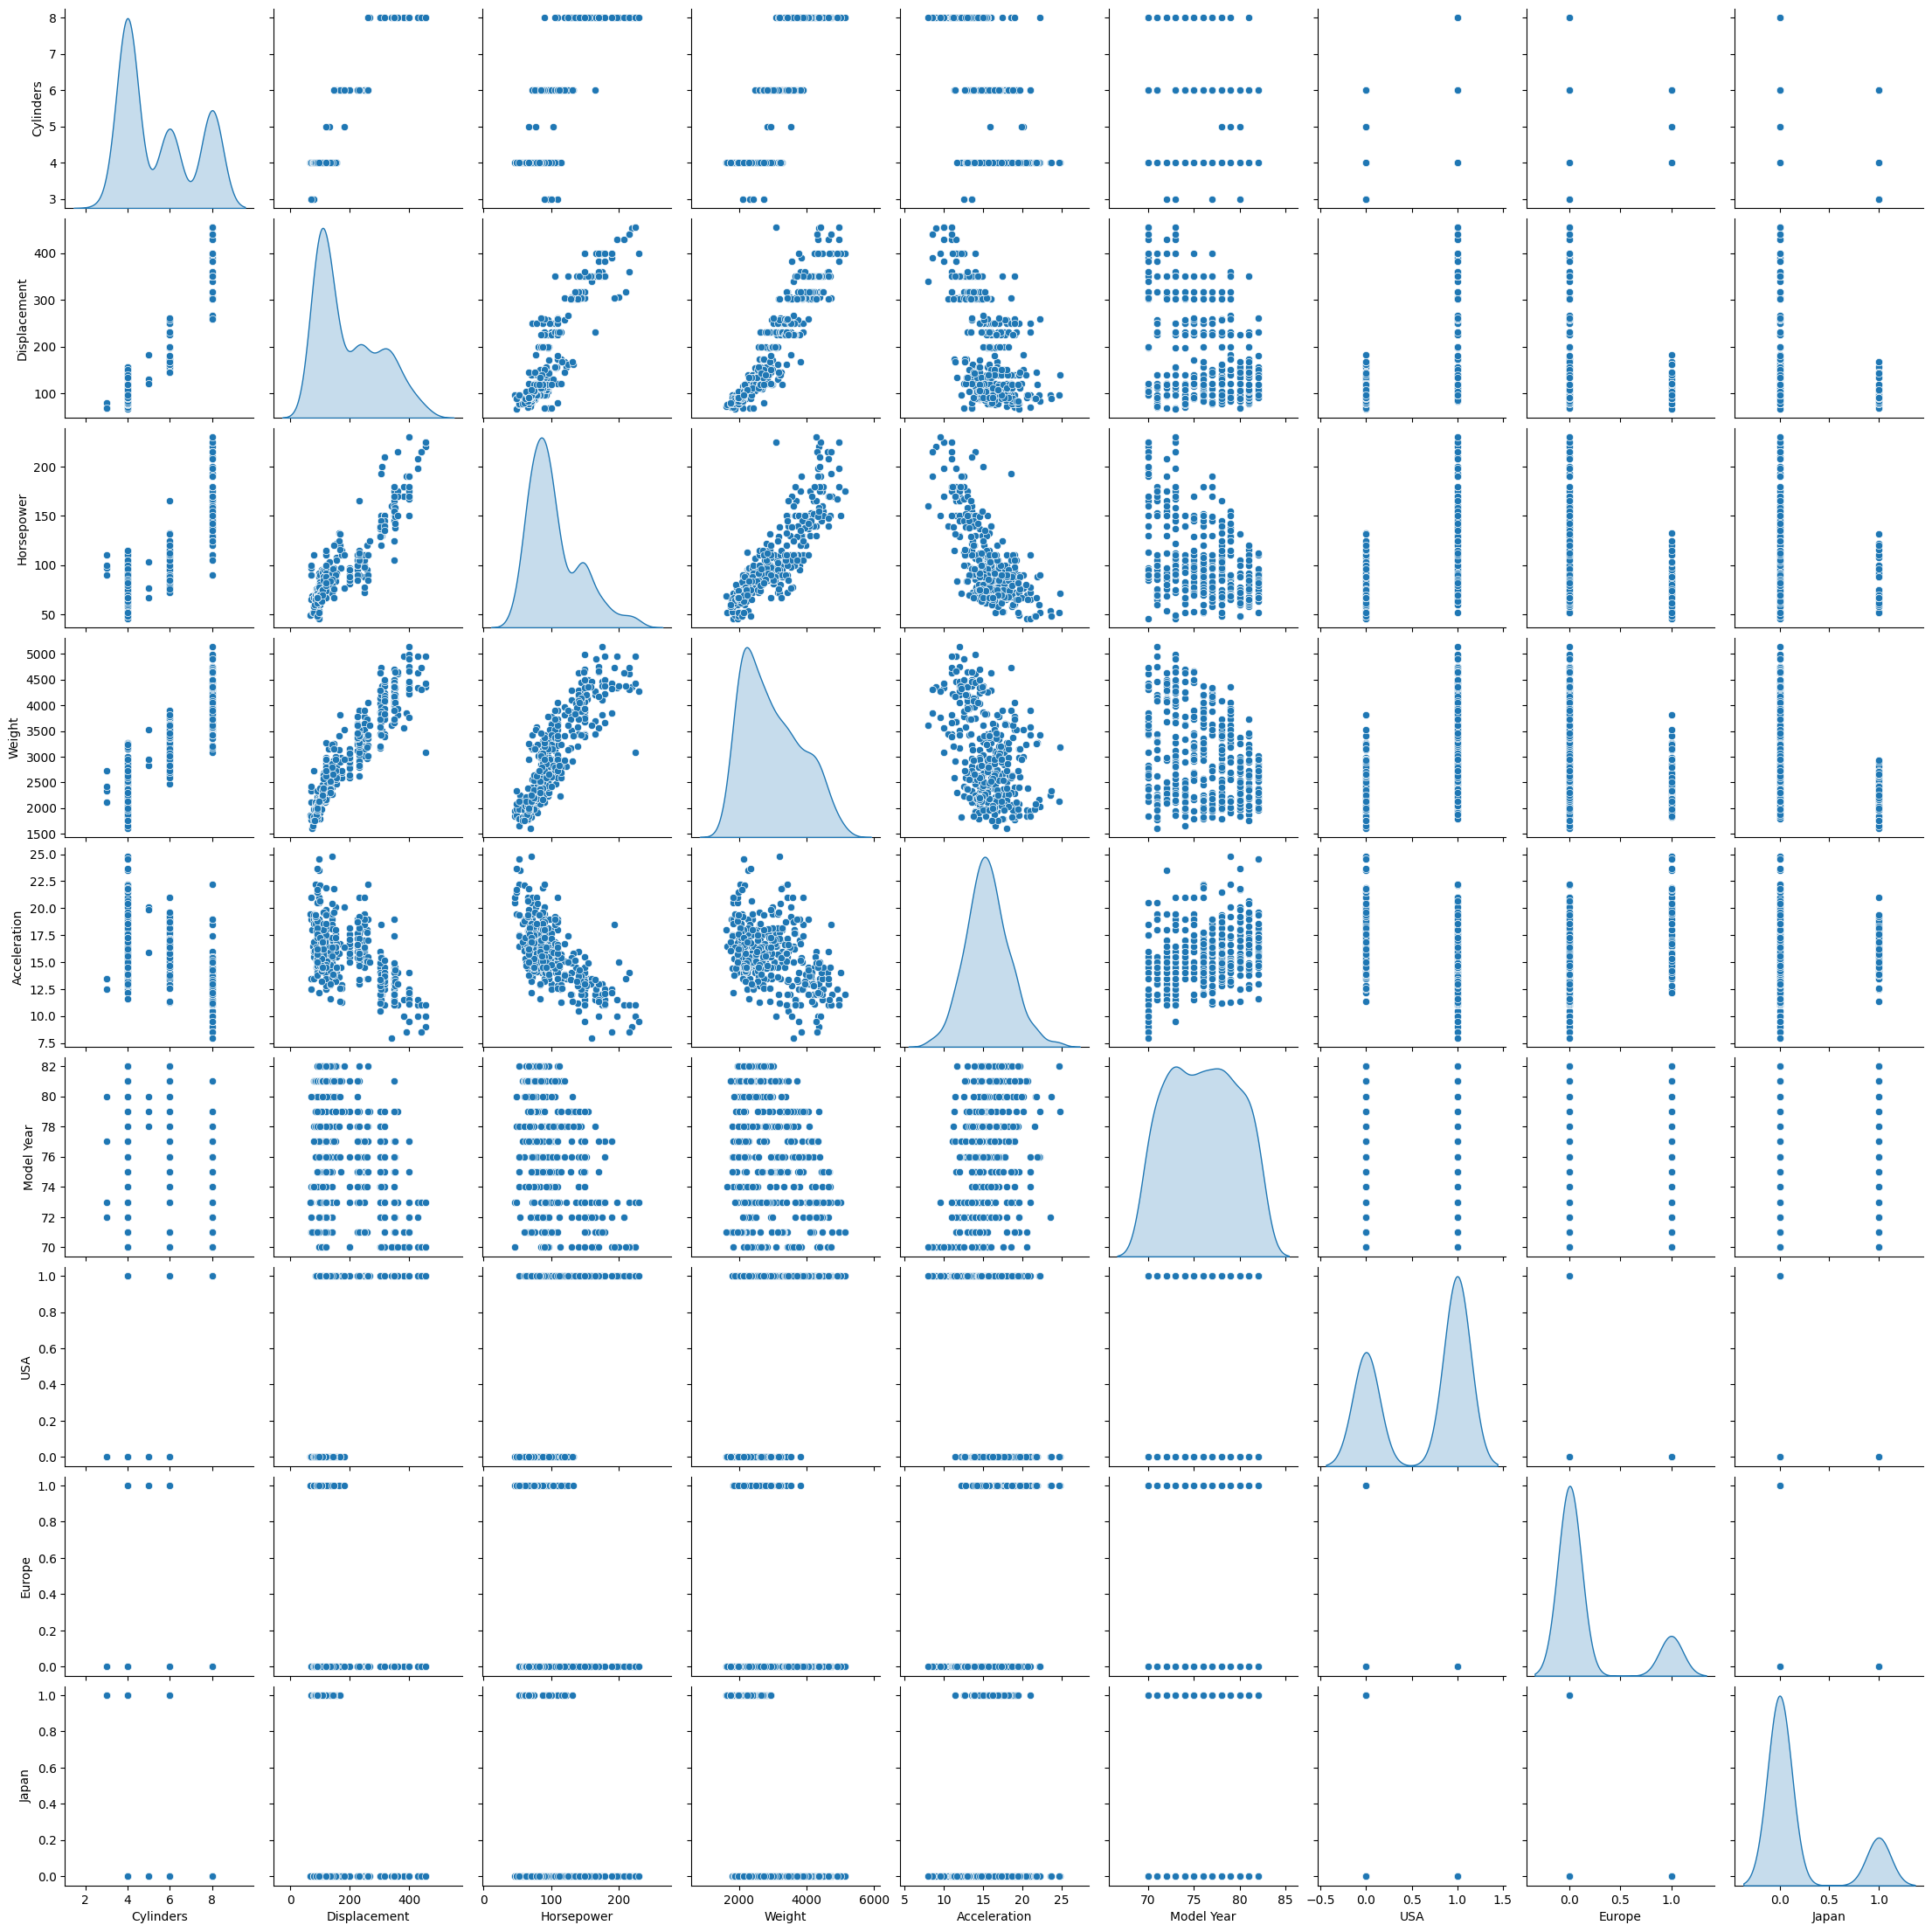

In [13]:
sns.pairplot(X, diag_kind='kde');

In [14]:
# normalización

X[X.columns] = StandardScaler().fit_transform(X)

In [15]:
X.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,0.774597,-0.458123,-0.50239
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,0.774597,-0.458123,-0.50239
2,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,0.774597,-0.458123,-0.50239
3,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,0.774597,-0.458123,-0.50239
4,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,0.774597,-0.458123,-0.50239


In [16]:
# separacion en paquetes de entrenamiento y testeo

X_train, X_test, y_train, y_test = tts(X, y)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((294, 9), (98, 9), (294,), (98,))

### Modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. 

In [18]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[X_train.shape[1]]))

model.add(Dense(64, activation='relu'))

model.add(Dense(1))



optimizer = RMSprop(0.001)



model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])  

In [19]:
# inspeccion del modelo

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrenamiento**

In [20]:
model.fit(X_train[:20], y_train[:20], epochs=2)

Epoch 1/2
1/1 [==============================] - 1s 730ms/step - loss: 646.9154 - mae: 24.3404 - mse: 646.9154
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 642.5162 - mae: 24.2511 - mse: 642.5162


In [21]:
class PrintDot(Callback):
    
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    else:
        print('.', end='')

In [22]:
EPOCAS = 1000

In [23]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [24]:
history

### Resultados

In [25]:
pd.DataFrame(history.history).head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,578.857849,22.768515,578.857849,536.189514,21.892645,536.189514
1,544.597961,22.027020,544.597961,504.338745,21.157623,504.338745
2,508.505676,21.197891,508.505676,467.515228,20.288721,467.515228
3,464.938324,20.170723,464.938324,423.433868,19.190725,423.433868
4,413.601166,18.876886,413.601166,370.370361,17.796225,370.370361


In [26]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show();

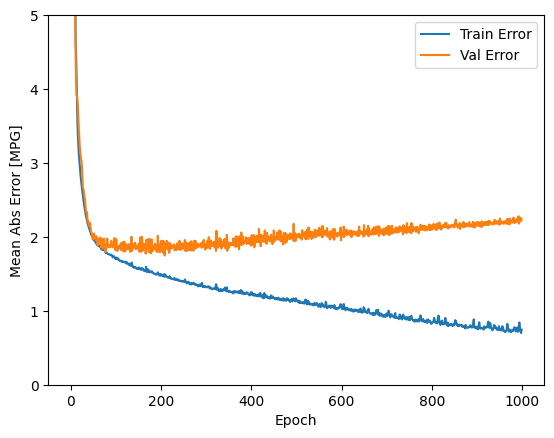

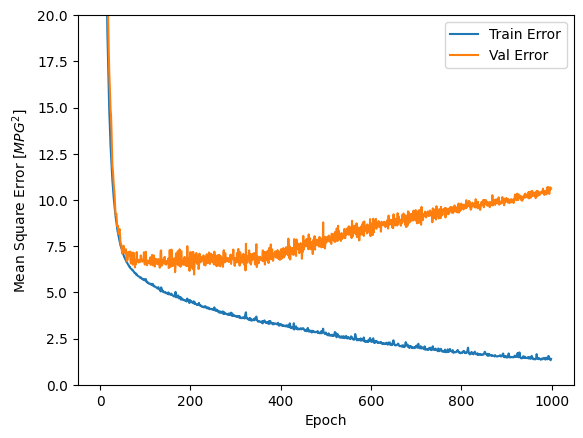

In [27]:
plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. 

Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre el callback [aquí](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [28]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[X_train.shape[1]]))

model.add(Dense(64, activation='relu'))

model.add(Dense(1))


optimizer = RMSprop(0.001)


model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])  

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [30]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])


.................................................................

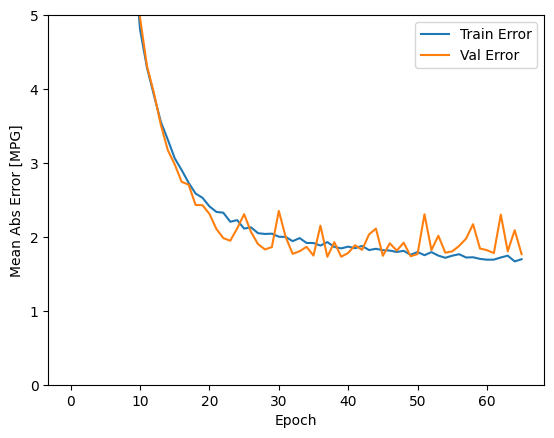

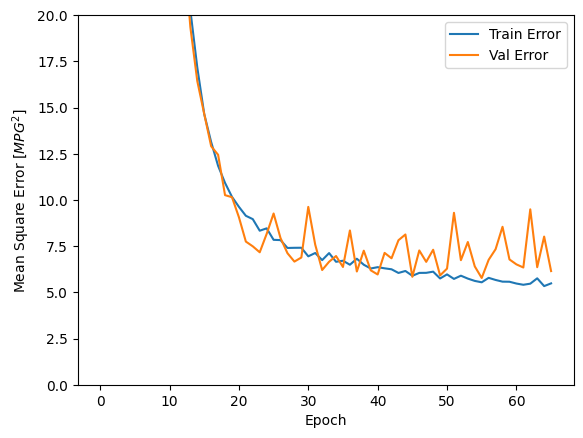

In [31]:
plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? 

Veamos qué tan bien generaliza el modelo al usar el conjunto de testeo, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

### Predicciones

In [32]:
y_pred = model.predict(X_test).flatten()

4/4 [==============================] - 0s 2ms/step


In [33]:
y_pred[:10]

array([18.608175, 28.58669 , 16.29132 , 15.914628, 31.1293  , 34.138367,
       33.150597, 34.935303, 34.22388 , 16.011917], dtype=float32)

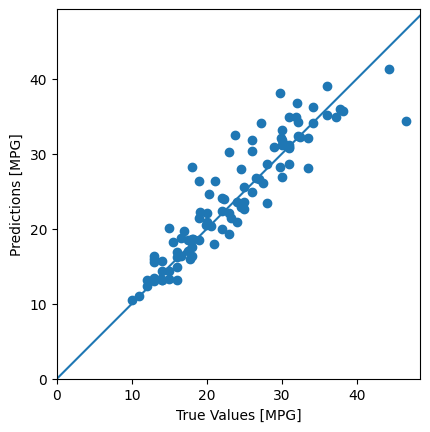

In [34]:
plt.scatter(y_test, y_pred)

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

plt.axis('equal')
plt.axis('square')

plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

In [35]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=1)

print('Testing MAE: {:5.2f} MPG'.format(mae))
print('Testing RMSE: {:5.2f} MPG'.format(mse**0.5))

4/4 [==============================] - 0s 4ms/step - loss: 10.5748 - mae: 2.2919 - mse: 10.5748
Testing MAE:  2.29 MPG
Testing RMSE:  3.25 MPG


In [36]:
y.mean(), y.std()

(23.445918367346938, 7.8050074865717995)

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

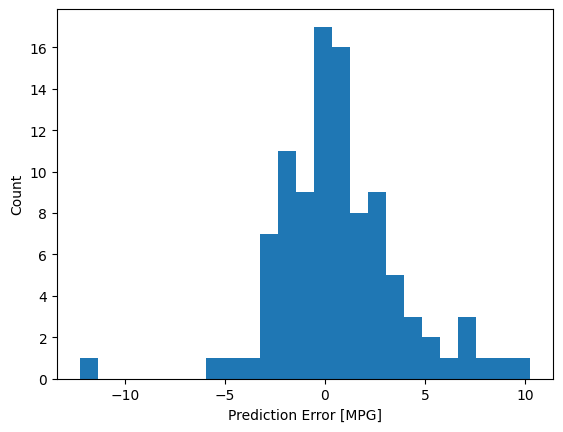

In [37]:
error = y_pred - y_test

plt.hist(error, bins = 25)

plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.